Transportation planning and assessments are important aspects of modeling urban systems and are critical in making key decisions and shaping/estimating the commute behavior of urban population.

Here we demonstrate a framework for transporation mode choice modeling using Bayesian inference. Essentially, we want to model commute across the city by estimating mode choices between origin-destination taxi zone pairs among 4 available modes - transit, taxi, walking and driving.

In [ ]:
# recommended in work in python 3.8
import pandas as pd
import numpy as np
from numpy import inf
from scipy.stats import norm
import itertools
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Data Souces
- the travel duration and fare cost for taxi, transit and driving modes
- the mobility information and aggregated income information
The combined data thus contains travel time, travel cost and aggregated commuter information corresponding to each of O-D pairs and 4 travel modes.

The travel modes (column 'tmode') contains codes for each mode referenced as- 2: transit, 3: taxi, 5: walking, 8: driving

In [ ]:
# read the data

path = ***

data = pd.read_csv(path + 'LEHD_commute.csv')
data['duration'] = data['duration']/60  # convert time to hours
data['ridership'] = data.iloc[:, 5:].sum(axis=1)  ## aggregate the ridership across income groups
data = data[['pulocationid', 'dolocationid', 'tmode', 'duration', 'price', 'ridership']]
data.head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,12.721600,736
1,3,7,3,0.798016,43.157143,0
2,3,18,3,0.254000,12.900000,1748
3,3,18,5,1.084444,0.000000,3174
4,3,18,8,0.268923,7.432000,10879


In [ ]:
data.ridership.sum() #Nearly 200 mln trips in total

np.int64(191552556)

In [ ]:
# number of unique O-D pairs

len(data[['pulocationid', 'dolocationid']].drop_duplicates())

19152

In [ ]:
# unique modes

data.tmode.unique()

array([8, 3, 5, 2])

([<matplotlib.axis.XTick at 0x7dbb6ba3cb50>,
 [Text(0, 0, 'Transit'),
  Text(1, 0, 'Taxi'),
  Text(2, 0, 'Walking'),
  Text(3, 0, 'Driving')])

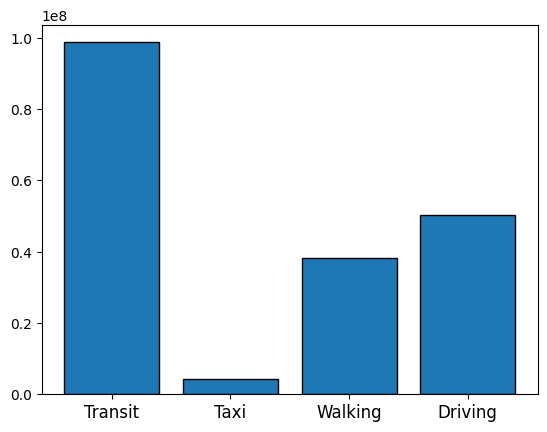

In [ ]:
## ridership by mode
byMode = data.groupby(by='tmode', as_index=False).sum()[['tmode', 'ridership']] #group by travel mode then sum the number of rodership
plt.bar(np.arange(len(byMode)), list(byMode.ridership), edgecolor = 'black') #creates the array of travel mode for x-axis,
# list() convewrst the ridership column to a s list, then the list is used as the height of the bars
plt.xticks([r  for r in range(len(byMode))], ['Transit', 'Taxi',
                                                      'Walking', 'Driving'], fontsize=12)

We use the Multinomial Logit (MNL) as the modeling framework for estimating the mode choice probabilities. MNL is broadly used in transportation choice modeling. It offers an advantage of estimating the mode-choice probabilities using closed-form formulas representing the aggregate-level choices.

the probabilities for each of the four major transportation modes to be chosen as having the highest utility is defined as
$$
\begin{equation}
    P_{mode} = \frac{e^{\lambda U_{mode}}}{e^{\lambda U_{taxi}} + e^{\lambda U_{transit}} + e^{\lambda U_{walk}} + e^{\lambda U_{drive}}}
\end{equation} \ (1)
$$

$\lambda$ being subject to fit.

Additionally, we define the utilily below.

Mathematically, the utility score $U_j$ for alternative ${j}$ depends on the time taken $T_j$ between the O-D pair in consideration and the monetary cost $P_j$ for choosing the alternative, and a random component of error $\epsilon_j$ , yielding a base utility function
$$
\begin{equation}
    U_j = -(CT_j + P_j)
\end{equation}$$

where C is kept as a constant.

The utility can be interpreted as perceived total 'value' of commuting between a o-d pair by the commuter, incorporating possible irrationality of individual decisions while combining it with the direct monetary cost to assess the overall utility. An additional random error term $\epsilon$ can be added to the utility term following a particular distribution. This could be either an additive term or multiplicative term based on our preferences.
Here we will proceed with the additive case, so the utility being defined as $\begin{equation}
    U_j = -(CT_j + P_j) + \epsilon
\end{equation}$


#### Likelihood estimation

From the estimated probabilities $P_m$, we compute the likelihood of the observed LEHD data give the model for each set of $\beta, \sigma$ parameters. For mode choice probabilities $P_m(o,d,\sigma,\beta)$ for each set of origin(o) and destination(d), the log-likelihood for four modes given the observed LEHD ridership $R_m(o,d)$ is calculated as
$$
\begin{equation}
    L(\sigma, \beta) = \sum_{o,d}\sum_m R_m(o,d)\ln P_m(o,d,\sigma,\beta)
\end{equation}
$$


One can simulate the results just for the max-likelihood parameters, however comprehensive parameter sampling provides assessment with respect to the model uncertainty.



In [ ]:
# choice for constant C - put as median hourly NYC income (assume all agents are rational and value their time as "face value"; in reality its not always the case and one may consider an additional parameter to scale the objective time value to a subjective estimate)
# our study shows this "rationality" parameter could be as low as 10%!
# NYC median income is ~ $33,220 per year

C = 0.1 * 33220/(12 * 180); C

1.537962962962963

In [ ]:
data['U'] = - C * data['duration'] - data['price']

As defined in the utility function, the coefficient C can be interpreted as a parameter incorporating irrationality of decisions based on time and cost.

We use the total number of hours in a day instead of number of working hours to assess the cost of time as people often underestimate the value of time.  So we try a lower bound value (which apparently also provides a better fit to the data). It could be a good idea to fit C as another parameter of the model, but we keep it fixed to make fitting easier for the illustration purposes.

# Predicting Transportation Modes for Unobserved OD Pairs
Now assume we know just part of the mobility flows, but not all of them (see training sample defined below). Assess the mobility flows with respect to the transportation mode for the reaming pairs of origin-detination locations

In [ ]:
#define total number of commutes per origin - detination pair from the ground-truth data (aggregating all the modes together)
ODflows = data[['pulocationid', 'dolocationid', 'ridership']].groupby(['pulocationid', 'dolocationid']).sum()
ODflows.rename(columns = {'ridership': 'total_commute'}, inplace = True) #Total commute for this OD_pair
ODflows.head()

total_commute
pulocationid dolocationid               
3            7                       736
             18                    15801
             20                     8418
             24                     7429
             31                      483

In [ ]:
data = data.join(ODflows, on = ['pulocationid', 'dolocationid'])
#join() combied two dataframes based on Origin and Destination to get the total commute for each OD-Pair

In [ ]:
data.head()

,pulocationid,dolocationid,tmode,duration,price,ridership,U,total_commute
0,3,7,8,0.653356,12.721600,736,-13.726437,736
1,3,7,3,0.798016,43.157143,0,-44.384462,736
2,3,18,3,0.254000,12.900000,1748,-13.290643,15801
3,3,18,5,1.084444,0.000000,3174,-1.667835,15801
4,3,18,8,0.268923,7.432000,10879,-7.845594,15801


In [ ]:
#define the training set
np.random.seed(1)
train_locations = np.random.choice(np.unique(data['pulocationid']), size = 30, replace = False); train_locations.sort()
train_locations

array([  7,  31,  38,  42,  55,  63,  72,  78,  83,  96, 101, 115, 119,
       131, 186, 189, 191, 195, 197, 199, 223, 227, 229, 236, 237, 240,
       254, 256, 260, 263])

In [ ]:
#leave only the flows from training set
train_data = data.loc[data['pulocationid'].isin(train_locations) & data['dolocationid'].isin(train_locations)]
# select row where both 'pulocationid' and 'dolocationid'are present in the train_location
test_data = data.loc[~data['pulocationid'].isin(train_locations) & ~data['dolocationid'].isin(train_locations)]
# select row where 'pulocationid' nor 'dolocationid'are present in the train_location

In [ ]:
train_data.head()

,pulocationid,dolocationid,tmode,duration,price,ridership,U,total_commute
533,7,83,8,0.299368,6.849358,5704,-7.309774,13731
534,7,83,5,3.913333,0.000000,713,-6.018562,13731
535,7,83,2,0.516667,2.750000,6808,-3.544614,13731
536,7,83,3,0.348206,12.691395,506,-13.226922,13731
555,7,101,3,0.708611,50.000000,23,-51.089818,2852


In [ ]:
test_data.head()

,pulocationid,dolocationid,tmode,duration,price,ridership,U,total_commute
2,3,18,3,0.254000,12.900,1748,-13.290643,15801
3,3,18,5,1.084444,0.000,3174,-1.667835,15801
4,3,18,8,0.268923,7.432,10879,-7.845594,15801
5,3,20,5,1.086389,0.000,299,-1.670826,8418
6,3,20,2,0.600000,2.750,4577,-3.672778,8418


## Estimating λ Using Cumulative Log-Likelihood

Fit model (1) across λ values from 0.1 to 0.15 with a 0.00001 step. Calculate the cumulative log-likelihood for the training data at each λ and identify the λ with the highest value. Convert log-likelihoods to likelihoods (or relative likelihoods) to avoid underflow, then compute the likelihood-weighted mean, standard deviation, and 99.9% confidence interval for λ.

Log-Likelihood: Quantifies the probability of observing the actual ridership given the model's predicited probabilities. The log-likelihood is summed up across all OD Pair and all mod

**Log-Likelihood**: Quantifies the probability of observing the actual ridership given the model's predicited probabilities.

The log-likelihood is summed up across all OD Pair and all mode

In [ ]:
def MNL(lambda_, data):  # multinomial logit probabilities and ridership estimated per O-D-mode
    # compute choice probabilities from mode utility defined above
    data1 = data.copy()
    data1['P'] = np.exp(lambda_ * data['U']) #取U指数为出行模式的概率
    top_P = data1[['pulocationid', 'dolocationid', 'P']].groupby(['pulocationid', 'dolocationid']).sum() #所有模式的概率总和 Probability of All Modes
    top_P.rename(columns = {'P' : 'top_P'}, inplace = True)
    data1 = data1.join(top_P, on = ['pulocationid', 'dolocationid']) #joins the probability of all modes back to original data
    data1['P'] /= data1['top_P'] #divides the Probability of choosing one mode to the probability of all modes in this od pair
    # This division normalizes the exponential utilities so that the probabilities for all modes within an O-D pair sum up to 1
    data1['estimated_ridership'] = data1['total_commute'] * data1['P'] #estimate ridership for this od pair using
    return data1

In [ ]:
MNL(0.1, data) #example of applying the model with an arbitrary chosen lambda

,pulocationid,dolocationid,tmode,duration,price,ridership,U,total_commute,P,top_P,estimated_ridership
0,3,7,8,0.653356,12.721600,736,-13.726437,736,0.955460,0.265250,703.218473
1,3,7,3,0.798016,43.157143,0,-44.384462,736,0.044540,0.265250,32.781527
2,3,18,3,0.254000,12.900000,1748,-13.290643,15801,0.168891,1.567428,2668.649825
3,3,18,5,1.084444,0.000000,3174,-1.667835,15801,0.539982,1.567428,8532.252386
4,3,18,8,0.268923,7.432000,10879,-7.845594,15801,0.291127,1.567428,4600.097788
...,...,...,...,...,...,...,...,...,...,...,...
38224,263,261,8,0.423988,24.843939,46,-25.496016,92,0.519197,0.150449,47.766132
38225,263,262,3,0.109960,5.100715,1840,-5.269829,111205,0.233912,2.523959,26012.154961
38226,263,262,2,0.133333,2.750000,7705,-2.955062,111205,0.294836,2.523959,32787.280613
38227,263,262,8,0.109435,15.386033,7981,-15.554340,111205,0.083638,2.523959,9300.915517


In [ ]:
def like(lambda_, data): #compute cumulative log-likelihood of a model with a given lambda_ fitted to the data
  data1 = MNL(lambda_, data)
  LL = (data1['ridership'] * np.log(data1['P'])).sum() # Multiplies observed ridership by the log of predicited probability
  # since P is the exponential probabilities, log the probabilities for easy interpretation
  # Sums over all rows (O-D-mode combinations).
  return LL

In [ ]:
lambdas = np.arange(0.1, 0.15, 0.00001) #range of lambdas
LLs = np.array([like(l, train_data) for l in lambdas]) #corresponding avg. log-likelihoods for each I in lambda array
# Computes MNL probabilities using MNL(lambda_, data).

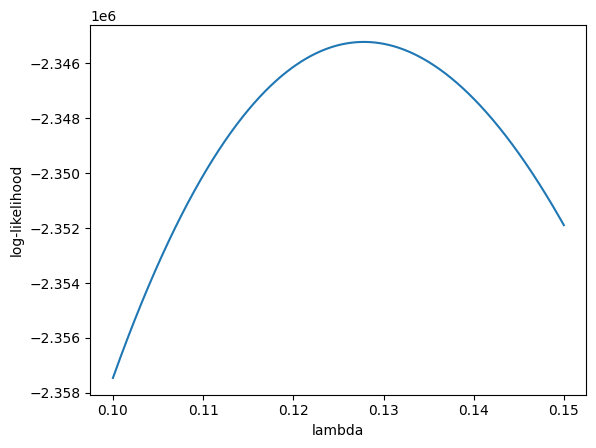

In [ ]:
plt.figure()
plt.xlabel('lambda')
plt.ylabel('log-likelihood')
plt.plot(lambdas, LLs)
plt.show()

In [ ]:
print('Best lambda = {:.6f}'.format(lambdas[np.argmax(LLs)]))
# np.argmax(arr): used to find the index of the maximum value in array
# which the index correspond to lambda

Best lambda = 0.127830


In [ ]:
def mustd(x, l): #return likelihood-weighted mean and std
    mu = (x * l).sum() / l.sum()
    #x: A NumPy array containing the values for which you want to calculate the weighted mean and standard deviation (in this case, the lambda values).
    #l: A NumPy array containing the corresponding likelihoods or weights for each value in x.
    std = (((x ** 2) * l).sum() / l.sum() - mu ** 2) ** 0.5 #
    return mu, std

In [ ]:
L = np.exp(LLs - max(LLs)) # Transform the large negative number to relative likelihood, while maintaining the relative differences
mu, std = mustd(lambdas, L)
print('Lambda mean+-std = {:.8f} +- {:.8f}'.format(mu, std))

Lambda mean+-std = 0.12782524 +- 0.00018578


In [ ]:
L

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
def confidence_interval(values, probabilities, confidence_level=0.95):
    # Sort values and associated probabilities
    sorted_indices = np.argsort(values) #tells the indices of sorted values
    sorted_values = np.array(values)[sorted_indices] # Sort λ in ascending order
    sorted_probabilities = np.array(probabilities)[sorted_indices] # Sort likelihood accoordingly

    # Compute cumulative probabilities
    cumulative_probabilities = np.cumsum(sorted_probabilities) # Cumulative Distribution Function（CDF) of the probabilities

    # Find the bounds
    lower_bound_idx = np.where(cumulative_probabilities >= (1 - confidence_level) / 2)[0][0] # find all indices where the cumulative probabilitye meets or exceed threshold
    # (1 - confidence_level) / 2 calculate how much
    upper_bound_idx = np.where(cumulative_probabilities <= 1 - (1 - confidence_level) / 2)[0][-1] # find all indices where the cumulative probabilitye is at or below threshold
    # [0] - First element of the tuple returned by np.where
    #[0][0] - First index from those that meet the condition (the earliest point where the cumulative probability crosses the threshold)
    #[0][-1] - First index from those that meet the condition (the last point before the cumulative probability exceeds the threshold)
    # Get the confidence interval values
    return sorted_values[lower_bound_idx], sorted_values[upper_bound_idx]

In [ ]:
CI = confidence_interval(lambdas, L, confidence_level=0.999)
print('99.9\% CI = ({:.5f}..{:.5f})'.format(CI[0], CI[1]))

99.9\% CI = (0.12704..0.12744)


## Posterior-Likelihood-Based Ridership Estimation
Use the posterior likelihood of λ caculated above to evaluate model predictions on the test set. For each O - D pair, run the model across all λ values in the given range and compute the likelihood-weighted mean and standard deviation of predicted ridership. Store these as est_ridership_mu and est_ridership_std in the test set dataframe.

In [ ]:
s = 0 # accumlates the weighted sum of ridership predictions
s2 = 0 # accumlates the weighted sum of squared ridership predictions
for i in range(len(lambdas)): #For each λ in lambdas
  er = MNL(lambdas[i], test_data)['estimated_ridership'] # compute choices probabilities and predicted ridership for the test using the given lamba
  # er contains the estimated ridership values for all O-D pairs
  s = s + er * L[i] # weights the predictions by their likelihood (L[i]) and adds to the running sum.
  s2 = s2 + (er ** 2) * L[i] # does the same for squared predicitions for variance calculation
Ls = L.sum() # sums all likelihood weights
Ls += (Ls == 0)
mu = s / Ls # computes the likelihood weighted mean predicition
std = (s2 / Ls - mu ** 2) ** 0.5 # computes the weighted standard deviation (square root of variance).

In [ ]:
#add the model prediction mean and standard deviation (likelihood weighted) to the test_data dataframe and output the first 20 rows of it
test_data['est_ridership_mu'] = mu
test_data['est_ridership_std'] = std
test_data.iloc[:20]

,pulocationid,dolocationid,tmode,duration,price,ridership,U,total_commute,est_ridership_mu,est_ridership_std
2,3,18,3,0.254000,12.900000,1748,-13.290643,15801,2128.441761,3.316785
3,3,18,5,1.084444,0.000000,3174,-1.667835,15801,9403.455145,5.650912
4,3,18,8,0.268923,7.432000,10879,-7.845594,15801,4269.103093,2.334129
5,3,20,5,1.086389,0.000000,299,-1.670826,8418,3678.691326,1.262086
6,3,20,2,0.600000,2.750000,4577,-3.672778,8418,2848.114046,0.082134
7,3,20,8,0.193898,6.577760,3542,-6.875968,8418,1891.194628,1.179952
8,3,24,2,1.033333,8.250000,7429,-9.839228,7429,7429.000000,NaN
11,3,32,2,0.183333,2.750000,8602,-3.031960,105570,35047.924283,2.322875
12,3,32,3,0.103602,6.183333,2300,-6.342669,105570,22954.739398,15.639811
13,3,32,5,0.417778,0.000000,94668,-0.642527,105570,47567.336318,17.962682


## Custom Neural Network model for mode-choice probabilities

The Multinomial logit model above is based on having closed form solutions for mode probabilites under certain assumptions about the individual choice factors. However not depending on that allow us to have further flexibility in choosing the modeling framework.

Let's introduce a simulation based approach for individual choice probabilities. Here, for each o-d pair we assess utility based on travel time and cost estimates as well as a random factor, representing individual preferences towards each mode as $U = -(T*C + P) * \epsilon$, where T is the travel time estimate, P is the travel fare/cost estimate and C is the adjustment for hourly income for NYC. The random factor $\epsilon$ is considered to be a random log-normally distributed variable, such that
$$
\epsilon = e^\varepsilon, \varepsilon\sim N(0, \sigma^2)
$$
where $\sigma$ defining the average relative "strength" of the individual choice factors is going to be a parameter of our model.

The mode-choice probabilities are then directly determined by the maximum utilities of 4 modes in question for a given o-d pair.

Unlike the multinomial logit model setting, the model formulation above might not have a closed-form analytic solution for the choice probabilities, so we may need to perform the choice simulations directly. However, performing parameter estimation through simulations might be computationally costly. In order to streamline the computational process, we first implement a neural network (NN) model fitting the mode-choice probabilities between the four transportation mode as the function of their utilities with model parameters.

We'll simulate 50,000 random utilities to fit the NN, with the simulated utilities being the input to get probabilities as the outputs. The model architecture consists of three hidden layers with 8,12,8 neurons respectively, with a rectified linear unit ("relu") activation for hidden and sigmoid for the output layer trained on 'binary cross-entropy' objective function.

We can then use this trained NN model for estimating mode-choice probabilities for the LEHD mobility data (calculating the mode utilities for each o-d) instead of using simulations or explicit analytic formulas.

# Neural Network Modeling for Mode Choice Prediction

In [ ]:
from scipy.stats import norm
import tensorflow as tf
from tensorflow.keras.losses import kullback_leibler_divergence
from tensorflow.keras.losses import KLDivergence
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from numpy import nan

import time

In [ ]:
#simulate sampleN random utility vectors for N modes
def randomUS(N = 4, sampleN = 10000, muU = 0, sigmaU = 1, srange = [0, 1]):
  #sampleN：define sample size
  #muU=0：效用值 Uj 的正态分布均值（默认0）
  #sigmaU=1: 效用值 Uj 的正态分布标准差（默认1）
  #随机参数：S的均匀分布范围（默认[0, 1]）
    U = np.random.normal(loc = muU, scale = sigmaU, size = (sampleN, N)) #generates a 2D Numpy array U with the dimension of (sampleN,N)
    # Sample from a normal distribution with specific mean and standard deviation
    S = np.random.uniform(low = srange[0], high = srange[1], size = (sampleN, 1)) # sampled from a uniform distribution within the range specified by srange.
    # Representing the random component 'S' for each scenario
    return np.concatenate([U, S], axis = 1) # first N columns contain the utility for each mode, and the last contains the unobserved heterogenity

In [ ]:
#generate a random sample of U's and sigma's for further choice probability simulation and neural network training to model those
np.random.seed(1)
sampleN = 100000 #generate a utility randpm sample
US_train = randomUS(N = 4, sampleN = sampleN, muU = train_data['U'].mean(), sigmaU = train_data['U'].std(), srange = [0, 3])

In [ ]:
US_train

array([[  3.56374245, -18.53430621, -17.70828929, -23.09218901,
          0.46262842],
       [ -3.93638262, -35.23340797,   4.75423941, -20.01123547,
          1.4637368 ],
       [ -9.33581414, -14.95306301,   1.96044756, -32.84781688,
          2.8843034 ],
       ...,
       [-10.25952069, -27.95179492,  -3.33910599,   8.46486977,
          2.10115221],
       [-19.91824989,  -4.24134418, -26.96489599, -19.83640997,
          1.10676477],
       [-16.98127616,  -2.97040658, -17.58439192,  -6.51710127,
          1.97427942]])

In [ ]:
US_train.shape

(100000, 5)

In [ ]:
#function simulated choices probabilities
def simChoice(US, N):
    #U - scenarios with utilities n x m array, n - number of scenarios, m - number of mode
    #sigma - random component
    #N - number of simulations runs
    n = US.shape[0]; # Number of scenarios: access the first element of this tuple,
    m = US.shape[1] - 1  # Number of choices/modes (excluding the last column sigma)

    # Generate random noise (normal distribution), shaped (N, n, m)
    # Each element is scaled by the sigma value of that scenario
    e = np.random.normal(loc = 0, scale = 1, size = (N, n, m)) * US[:, -1].reshape((1, -1, 1)) #Creates a 3D array of Gaussian noise:

    # Compute simulated utilities:
    # Add randomness to deterministic utilities (excluding last column which is sigma)
    Usim = np.exp(e) * US[:, :-1]
    #np.exp(e) takes the exponential of scaled random noise e for a specific simulation
    #Multiplied by the original utility values for the same scenario across all modes


    # For each simulation and scenario, find the index of the highest utility (i.e., the chosen mode)
    ch = np.argmax(Usim, axis = 2) # shape: (N, n)
    p = []
    for k in range(m):
        # Count how many times each mode (k) was chosen in each scenario
        # (ch == k) returns a boolean array where mode k was chosen
        # Sum across simulations (axis=0) by entire column for each scenario
      p += [list((ch == k).sum(axis = 0))]

    # Transpose the list of counts to get shape: (n, m)
    p = np.array(p).T

    # Normalize counts to get probabilities by dividing by the whole simulations (sum of all mode) per scenario
    p = p / p.sum(axis = 1, keepdims = True)

    return p #returns thoe choice probabilities for each scenario of shape (n, m)

            Mode1 Mode2 Mode3 Mode4
Scenario1  
Scenario2   
.  
.  
.  
ScenarioN

In [ ]:
#assess the choice probabilities over 10.000 chunks of the training set of U's and sigma's
P_train = np.zeros((sampleN, 4)) #initializes a 2D array filed with zeros with size of (sampleN,4)
for i in range(sampleN // 10000 + 1): #iterates the data in chunks of 10,000
    P_train[(10000 * (i-1)) : (10000 * i), :] = simChoice(US = US_train[(10000 * (i-1)) : (10000 * i), :], N = 1000)
    #(10000 * （i-1) : (10000 * i) calculates the start and end indices for the current chunk of scenario and select from US_train
    #simChoice(US,N) calls the function with the current chunk and runs 1000 simulation
    # and then store in P_train array

In [ ]:
US_test = randomUS(N = 4, sampleN = 1000, muU = train_data['U'].mean(), sigmaU = train_data['U'].std(), srange = [0, 3])
#US_test = randomUS(N = 4, sampleN = 1000, muU = train_data['U'].mean(), sigmaU = train_data['U'].std(), srange = [0, 3])
P_test = simChoice(US = US_test, N = 1000)
# run 1000 simulations for each 1000 scenario

In [ ]:
P_train.shape

(100000, 4)

In [ ]:
P_test

array([[0.223, 0.516, 0.105, 0.156],
       [0.389, 0.281, 0.145, 0.185],
       [0.   , 0.   , 0.   , 1.   ],
       ...,
       [0.118, 0.136, 0.257, 0.489],
       [0.275, 0.158, 0.195, 0.372],
       [0.   , 0.   , 1.   , 0.   ]])

## NN Training with KL-Divergence and Likelihood Evaluation
Train a neural network (5 input neurons → 3 hidden layers with 10 neurons each → softmax output with 4 neurons) using simulated utilities and sigma as inputs to predict four transportation mode choice probabilities. Optimize with Adam, minimize KL divergence over 100 epochs (batch size 100). Evaluate on the test set by comparing predicted vs. actual probabilities for the first 10 training rows and compute overall KL divergence and MSE.

In [ ]:
model = Sequential() # A linear stack of layer
model.add(Dense(units=10, activation='relu', input_shape=(5,))) #add relu hiddden layer help network learn complex pattern
#input data will be a vector of length 5 (4 utilities and random component)
model.add(Dense(units=10, activation='relu')) # mitigate vanish gradient
model.add(Dense(units=10, activation='relu')) # 3 hidden layer
model.add(Dense(units=4, activation='softmax')) # output layer and converts into a probability distribution where the sum
# of all modes for a given input scenario will be 1
model.compile(loss=KLDivergence(), optimizer='adam', metrics=['categorical_accuracy'])

Kullback-Leibler Divergence:   
- Loss function measure how one probability distribution is different rom a second reference proability distribution.  

Adam Optimizer:

Categorical Accuracy: measures how often the model correctly predicts the mode with the highest probability.

In [ ]:
model.fit(US_train, P_train, epochs=100, batch_size=100, verbose=2)
# complete 100000/100 = 1000 batches in one epoch, repeated the process for 100 times

Epoch 1/100
1000/1000 - 2s - 2ms/step - categorical_accuracy: 0.8275 - loss: 0.2991
Epoch 2/100
1000/1000 - 3s - 3ms/step - categorical_accuracy: 0.9198 - loss: 0.1233
Epoch 3/100
1000/1000 - 1s - 1ms/step - categorical_accuracy: 0.9276 - loss: 0.0961
Epoch 4/100
1000/1000 - 2s - 2ms/step - categorical_accuracy: 0.9285 - loss: 0.0793
Epoch 5/100
1000/1000 - 1s - 1ms/step - categorical_accuracy: 0.9244 - loss: 0.0668
Epoch 6/100
1000/1000 - 2s - 2ms/step - categorical_accuracy: 0.9252 - loss: 0.0555
Epoch 7/100
1000/1000 - 2s - 2ms/step - categorical_accuracy: 0.9296 - loss: 0.0481
Epoch 8/100
1000/1000 - 1s - 1ms/step - categorical_accuracy: 0.9336 - loss: 0.0445
Epoch 9/100
1000/1000 - 2s - 2ms/step - categorical_accuracy: 0.9351 - loss: 0.0427
Epoch 10/100
1000/1000 - 1s - 1ms/step - categorical_accuracy: 0.9357 - loss: 0.0415
Epoch 11/100
1000/1000 - 1s - 1ms/step - categorical_accuracy: 0.9360 - loss: 0.0404
Epoch 12/100
1000/1000 - 2s - 2ms/step - categorical_accuracy: 0.9357 - lo

In [ ]:
KL_divergence = KLDivergence()(P_test, model.predict(US_test)).numpy()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
print("KL Divergence:", KL_divergence)

KL Divergence: 0.023508431


In [ ]:
from sklearn.metrics import mean_squared_error
mse_value = mean_squared_error(P_test, model.predict(US_test))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [ ]:
print("MSE:", mse_value)

MSE: 0.0025664061607836167


In [ ]:
for i in range(10):
    print(f"Row {i+1}")
    print("Predicted:", model.predict(US_test)[i])
    print("Actual:", P_test[i])

Row 1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predicted: [0.24207205 0.5191622  0.08499451 0.1537713 ]
Actual: [0.223 0.516 0.105 0.156]
Row 2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predicted: [0.44250858 0.24252528 0.13019043 0.18477567]
Actual: [0.389 0.281 0.145 0.185]
Row 3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predicted: [2.0466937e-13 3.3031727e-11 2.4615654e-10 9.9999994e-01]
Actual: [0. 0. 0. 1.]
Row 4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Predicted: [0.00253829 0.00264984 0.00239988 0.99241203]
Actual: [0. 0. 0. 1.]
Row 5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Predicted: [0.03884024 0.01722929 0.04453034 0.8994001 ]
Actual: [0.062 0.034 0.066 0.838]
Row 6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predicted: [0.46660122 0.15005848 0.28960156 0.0937387 ]
Actual: [0.354 0.227 0.252 0.167]
Row 7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predicted: [0.00408969 0.00133562 0.9879579  0.00661686]
Actual: [0. 0. 1. 0.]
Row 8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Predicted: [0.009265

## Apply Neural Network Model to Pevious Training Data (σ = 1)

In [ ]:
U_values = US_train[:, :4] #captures the utility of 4 mode from data
sigma_values = np.ones((U_values.shape[0], 1)) # fix the sigma values for every scenario

In [ ]:
U_values

array([[  3.56374245, -18.53430621, -17.70828929, -23.09218901],
       [ -3.93638262, -35.23340797,   4.75423941, -20.01123547],
       [ -9.33581414, -14.95306301,   1.96044756, -32.84781688],
       ...,
       [-10.25952069, -27.95179492,  -3.33910599,   8.46486977],
       [-19.91824989,  -4.24134418, -26.96489599, -19.83640997],
       [-16.98127616,  -2.97040658, -17.58439192,  -6.51710127]])

In [ ]:
sigma_values #influence randomness of the randome component of

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [ ]:
input_data = np.hstack((U_values, sigma_values))
input_data

array([[  3.56374245, -18.53430621, -17.70828929, -23.09218901,
          1.        ],
       [ -3.93638262, -35.23340797,   4.75423941, -20.01123547,
          1.        ],
       [ -9.33581414, -14.95306301,   1.96044756, -32.84781688,
          1.        ],
       ...,
       [-10.25952069, -27.95179492,  -3.33910599,   8.46486977,
          1.        ],
       [-19.91824989,  -4.24134418, -26.96489599, -19.83640997,
          1.        ],
       [-16.98127616,  -2.97040658, -17.58439192,  -6.51710127,
          1.        ]])

In [ ]:
predictions = model.predict(input_data)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 746us/step


In [ ]:
print("Predicted Probabilities for first 10 samples:")
print(predictions[:10])

Predicted Probabilities for first 10 samples:
[[9.9982333e-01 4.1824485e-05 8.5411091e-05 4.9519771e-05]
 [1.7763817e-04 1.5104585e-05 9.9975145e-01 5.5802164e-05]
 [1.2249222e-04 3.3566103e-05 9.9975824e-01 8.5781016e-05]
 [5.2962415e-02 3.2930568e-02 8.7579715e-01 3.8309816e-02]
 [2.1854536e-01 1.0213729e-01 2.6730442e-01 4.1201282e-01]
 [2.1315711e-02 7.8912246e-01 1.2512003e-01 6.4441852e-02]
 [6.0833538e-01 9.1426894e-02 1.7705572e-01 1.2318206e-01]
 [2.2562945e-01 4.5275772e-01 1.2498583e-01 1.9662699e-01]
 [2.5129324e-01 1.3673995e-01 2.0354243e-01 4.0842435e-01]
 [1.0424533e-04 4.6272620e-05 9.9955344e-01 2.9611157e-04]]


## Parameter Optimization - Sigma Selection via Likelihood Maximization
Test multiple values of σ within a chosen range to determine which maximizes the likelihood of the training data. Calculate and report the likelihood-weighted mean and standard deviation of σ.

In [ ]:
sigma_range = np.linspace(4.5, 6.5, 100) #set sigma range
# unobserved heterogeneity and controls the magnitude of randomness in utility simulations

In [ ]:
likelihoods = []

In [ ]:
for sigma in sigma_range:
    sigma_array = sigma * np.ones((len(US_train), 1)) #creat a sigma 1D erray for each in the range in the size of UStrain scenario numbers and 1
    input_data = np.hstack([US_train[:, 0:1], US_train[:, 1:2], US_train[:, 2:3], US_train[:, 3:4], sigma_array])
    probabilities = model.predict(input_data)

    likelihood = np.sum(np.log(probabilities)) #Sums the log-probabilities of all samples
    likelihoods.append(likelihood)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 741us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 870us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 763us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 879us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 820us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 955us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 936us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 846us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 773us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 797us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 792us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 856us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 788us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 775us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 852us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 775us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 789us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 810us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 772us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 938us/step
3125/3125 ━━━━

In [ ]:
max_likelihood_index = np.argmax(likelihoods) # Find the best log-likelihood
best_sigma = sigma_range[max_likelihood_index] # Selects the sigma with the highest log-likelihood.

In [ ]:
print("Best Sigma:", best_sigma)

Best Sigma: 6.5


In [ ]:
#Expected sigma value, weighted by likelihood.
weighted_mean = np.sum(likelihoods * sigma_range) / np.sum(likelihoods)

In [ ]:
#Uncertainty in the estimate
weighted_std = np.sqrt(np.sum(likelihoods * (sigma_range - weighted_mean)**2) / np.sum(likelihoods))

In [ ]:
print("Likelihood-Weighted Mean:", weighted_mean)
print("Likelihood-Weighted Standard Deviation:", weighted_std)

Likelihood-Weighted Mean: 5.476240140155208
Likelihood-Weighted Standard Deviation: 0.584201185119692


## Likelihood - Weighted Prediction on Test Set Across σ Range

Evaluate the model on the test set across your prior σ range. For each O–D pair, compute the likelihood‑weighted mean and likelihood‑weighted standard deviation of the predictions, write them to the dataframe, and output the first 20 rows.

In [ ]:
#generates an array of ones with the same length as sigma range
#normalizes it to sum to 1
likelihoods = np.ones(len(sigma_range)) / len(sigma_range)

In [ ]:
def probabilities(data, sigma_val):
    #apply unobserved heterogenity
    data['exp_sigma_U'] = np.exp(sigma_val * data['U'])

    #Group by O-D pairs and sum by each scenario
    sum_exp_sigma_U = data.groupby(['pulocationid', 'dolocationid'])['exp_sigma_U'].transform('sum')

    #compute choice probabilities
    data['P'] = data['exp_sigma_U'] / sum_exp_sigma_U
    return data

In [ ]:
def calculate_test_predictions(test_data, sigma_range):

    #Creates a matrix to store predictions for each sigma value (columns) and each data row (rows).
    predictions = np.zeros((len(test_data), len(sigma_range)))


    for idx, sigma in enumerate(sigma_range):
        #calculates probabilities (probabilities())
        temp_data = probabilities(test_data.copy(), sigma)
        #and scales them by total_commute (ridership count).
        predictions[:, idx] = temp_data['P'] * temp_data['total_commute']

    #Weighted average of predictions across sigmas
    means = np.average(predictions, weights=likelihoods, axis=1)
    #Weighted std of predictions across sigmas
    stds = np.sqrt(np.average((predictions - means[:, None])**2, weights=likelihoods, axis=1))

    test_data['est_ridership_mu'] = means
    test_data['est_ridership_std'] = stds

    return test_data

In [ ]:
test_data = calculate_test_predictions(test_data, sigma_range)

In [ ]:
test_data.head(20)

,pulocationid,dolocationid,tmode,duration,price,ridership,U,total_commute,est_ridership_mu,est_ridership_std
2,3,18,3,0.254000,12.900000,1748,-13.290643,15801,1.456210e-20,4.760396e-20
3,3,18,5,1.084444,0.000000,3174,-1.667835,15801,1.580100e+04,2.601805e-09
4,3,18,8,0.268923,7.432000,10879,-7.845594,15801,1.137438e-09,2.601756e-09
5,3,20,5,1.086389,0.000000,299,-1.670826,8418,8.417745e+03,2.669555e-01
6,3,20,2,0.600000,2.750000,4577,-3.672778,8418,2.552371e-01,2.669554e-01
7,3,20,8,0.193898,6.577760,3542,-6.875968,8418,5.667932e-08,1.168888e-07
8,3,24,2,1.033333,8.250000,7429,-9.839228,7429,7.429000e+03,0.000000e+00
11,3,32,2,0.183333,2.750000,8602,-3.031960,105570,4.754054e-01,5.728684e-01
12,3,32,3,0.103602,6.183333,2300,-6.342669,105570,7.032063e-08,1.532836e-07
13,3,32,5,0.417778,0.000000,94668,-0.642527,105570,1.055695e+05,5.728686e-01
